/Users/didi/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Search Best Estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1850,
       silent=True, subsample=0.8)
Best Score:
0.150348708667

Model Report:
r2_score : 0.8568


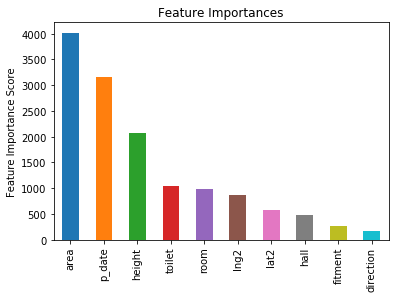


Test:


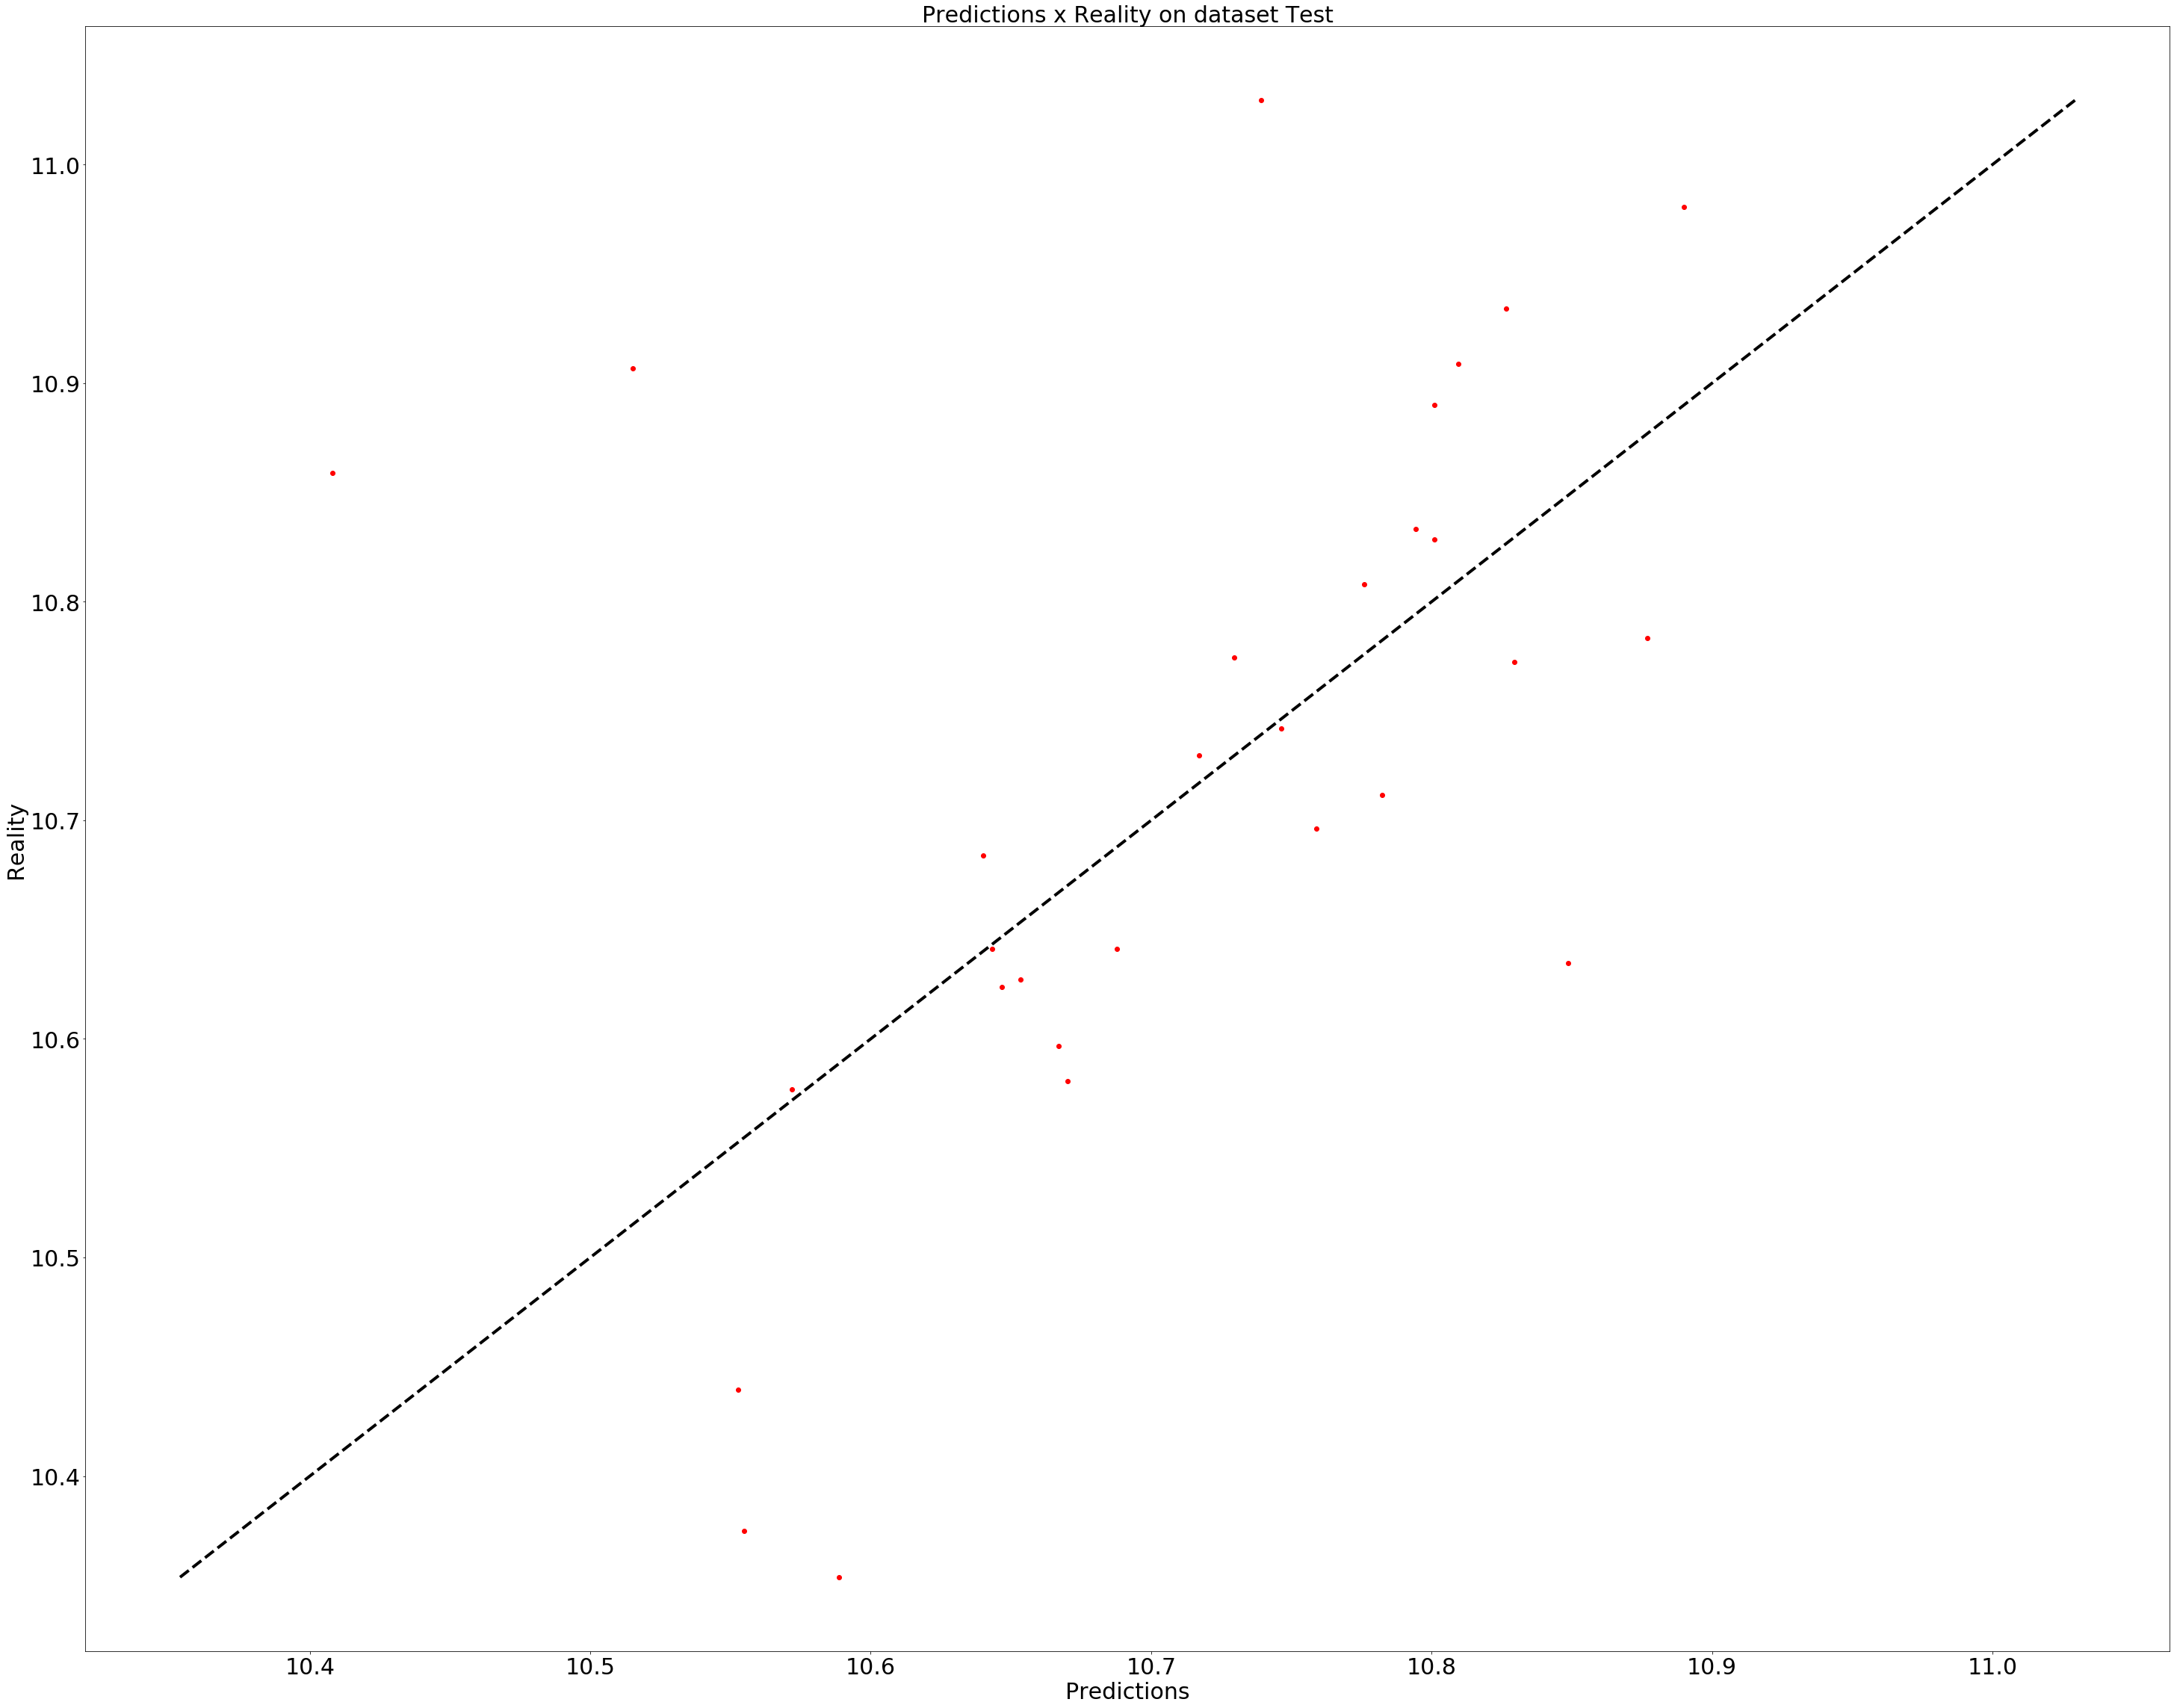

In [1]:
# -*- coding: utf-8 -*-
"""
Created on TODAY

@author: lumin
"""

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

# step1 检查源数据集，读入数据，将csv数据转换为DataFrame数据
train_df = pd.read_excel("train.xls",index_col = 0)
test_df = pd.read_excel('test.xls',index_col = 0)
# print train_df.shape
# print test_df.shape
# print train_df.head()  # 默认展示前五行 这里是5行,80列
# print test_df.head()   # 这里是5行,79列

# step2 合并数据，进行数据预处理,
# 返回x+1的自然对数(基数为e)的值
# prices = pd.DataFrame({'price':train_df['SalePrice'],
#                       'log(price+1)':np.log1p(train_df['SalePrice'])})
# ps = prices.hist()
# plt.plot()
# plt.show()

y_train = np.log1p(train_df.pop('SalePrice'))
y_test = np.log1p(test_df.pop('SalePrice'))
all_df = pd.concat((train_df,test_df),axis = 0)
#print all_df.shape
#print all_df.head()

# step3 变量转化
mean_cols = all_df.mean()
all_dummy_df = all_df
all_dummy_df = all_dummy_df.fillna(mean_cols)
# print (all_dummy_df.isnull().sum().sum())

# 标准化numerical数据
numeric_cols = all_df.columns[all_df.dtypes != 'object']
# print (numeric_cols)

numeric_col_means = all_dummy_df.loc[:,numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:,numeric_cols].std()
all_dummy_df.loc[:,numeric_cols] = (all_dummy_df.loc[:,numeric_cols] - numeric_col_means) / numeric_col_std

# step4 把数据处理之后，分离训练集和测试集
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
# print (dummy_train_df.shape,dummy_test_df.shape)

# 将DF数据转换成Numpy Array的形式，更好地配合sklearn
# X_train = dummy_train_df.values
# X_test = dummy_test_df.values
# print dummy_train_df.shape
# print dummy_train_df.head()

X_train = dummy_train_df
X_test = dummy_test_df

# step5 训练模型
def checkmodel(alg, X_train, y_train):
    # Predict training set:
    y_train_prediction = alg.predict(X_train)

    #Print model report:
    print "\nModel Report:"
    print "r2_score : %.4g" % metrics.r2_score(y_train, y_train_prediction)

    # Choose important features
    # plot_importance(alg)
    # plt.show()
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
def predict(alg, X_test, y_test):
    print "\nTest:"
    y_test_prediction = alg.predict(X_test)
    
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30) 

    fig, ax = plt.subplots(figsize=(50, 40))
    
    plt.style.use('ggplot')
    plt.plot(y_test_prediction, y_test, 'ro')
    plt.xlabel('Predictions', fontsize = 30)
    plt.ylabel('Reality', fontsize = 30)
    plt.title('Predictions x Reality on dataset Test', fontsize = 30)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {
    'base_score' : [0.5],
    'colsample_bylevel' : [1],
    'colsample_bytree' : [0.7],
    'gamma' : [0],
    'learning_rate' : [0.01],
    'n_estimators' : [1000],
    'max_delta_step' : [0],
    'max_depth' : [5],
    'min_child_weight' : [2],
    'nthread' : [-1],
    'objective' : ['reg:linear'],
    'reg_alpha' : [0],
    'reg_lambda' : [1],
    'scale_pos_weight' : [1],
    'seed' : [1850],
    'silent' : [True],
    'subsample' : [0.8]
}

xgb_grid = GridSearchCV(
    xgb1,
    parameters,
    n_jobs = 5,
)
xgb_grid.fit(X_train, y_train, eval_metric='rmse')
print "Search Best Estimator:"
print xgb_grid.best_estimator_
print "Best Score:"
print xgb_grid.best_score_

checkmodel(xgb_grid.best_estimator_, X_train, y_train)
predict(xgb_grid.best_estimator_, X_test, y_test)